Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

Some adaptations are made, original source: https://github.com/Azure/azureml-examples/tree/main/sdk/python/jobs/automl-standalone-jobs/automl-forecasting-github-dau

### **Forecasting using a batch endpoint**

#### **Preparation**

**import required libraries**

In [1]:
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

**import data**


We will use github active user (DAU) count for model training. The data is stored in a tabular format.

With Azure Machine Learning MLTables you can keep a single copy of data in your storage, easily access data during model training, share data and collaborate with other users. 
Below, we will upload the data by creating an MLTable to be used for training.

In [2]:
#pip install azureml-dataset-runtime --upgrade

from azureml.core import Workspace, Dataset, Experiment 
ws = Workspace.from_config()
test_df = Dataset.get_by_name(ws, name="Github_DAU_test", version="1").to_pandas_dataframe() #uci_electro_small_public_tcn_infer
test_df

,date,count,day_of_week,month_of_year,holiday
0,2017-06-04,104663,6.0,5.0,0.0
1,2017-06-05,155824,0.0,5.0,0.0
2,2017-06-06,164908,1.0,5.0,0.0
3,2017-06-07,170309,2.0,5.0,0.0
4,2017-06-08,164256,3.0,5.0,0.0
...,...,...,...,...,...
449,2018-08-27,180142,0.0,7.0,0.0
450,2018-08-28,191628,1.0,7.0,0.0
451,2018-08-29,191149,2.0,7.0,0.0
452,2018-08-30,187503,3.0,7.0,0.0


In [3]:
os.makedirs("test_dataset", exist_ok=True)
test_df.to_csv(os.path.join("test_dataset", "test_data.csv"), index=False)

In [4]:
my_test_data_input = Input(
    type=AssetTypes.URI_FOLDER,
    path="test_dataset/",
)

In [5]:
my_test_data_input

{'type': 'uri_folder', 'path': 'test_dataset/', 'mode': 'ro_mount'}

In [6]:
# general job parameters

target_column_name = "count"
forecast_horizon = 14
time_column_name = "date"

**Configure workspace details and get a handle to the workspace**

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.

In [7]:
from azure.ai.ml import MLClient
from azure.identity import (
    DefaultAzureCredential,
    AzureCliCredential,
    ChainedTokenCredential,
)

In [8]:
import os 
from dotenv import load_dotenv
load_dotenv("credentials.env")

DEFAULT_CREDENTIAL = DefaultAzureCredential()
CLI_CREDENTIAL = AzureCliCredential()
CREDENTIAL_CHAIN = ChainedTokenCredential(CLI_CREDENTIAL, DEFAULT_CREDENTIAL)
subscription_id = os.environ['SUBSCRIPTION_ID']
resource_group = os.environ['RESOURCE_GROUP_NAME']
workspace = os.environ['WORKSPACE_NAME']

ml_client = MLClient(CREDENTIAL_CHAIN, subscription_id, resource_group, workspace)

#### **Forecasting using batch endpoint**

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. We will do batch scoring on the test dataset which must have the same schema as training dataset.

The inference will run on a remote compute. First we need to create compute and then load model and environment from the local file.


**Is the model registered already?**

In [ ]:
models = ml_client.models.list()
for model in models:
    print(model.name)

In [ ]:
model_name = "TCNForecaster-GitHub-dau" #"uci-small-tcn-model-202309141713"
model_version = "1"

model_example = ml_client.models.get(name= model_name, version = model_version)
print(model_example)

**create model endpoint**

A batch endpoint is an HTTPS endpoint that clients can call to trigger a batch scoring job. A batch scoring job is a job that scores multiple inputs (for more, see What are batch endpoints?). A batch deployment is a set of compute resources hosting the model that does the actual batch scoring. One batch endpoint can have multiple batch deployments.

In [12]:
from azure.ai.ml.constants import BatchDeploymentOutputAction

import datetime
from azure.ai.ml.entities import (
    Environment,
    BatchEndpoint,
    BatchDeployment,
    BatchRetrySettings,
    Model,
)

batch_endpoint_name = "github-dau-batch-" + datetime.datetime.now().strftime("%m%d%H%M%f")

endpoint = BatchEndpoint(
    name=batch_endpoint_name,
    description="this is a sample batch endpoint",
)

In [ ]:
ml_client.begin_create_or_update(endpoint)

**create batch deployment**

To create a batch deployment, we will use the forecasting_script.py which will load the model and will call forecast each time we will envoke the endpoint.

A model deployment is a set of resources required for hosting the model that does the actual inferencing. To create a batch model deployment, you need all the following items:

A registered model in the workspace.
The code to score the model.
The environment with the model's dependencies installed.
The pre-created compute and resource settings.

In [14]:
env = Environment(
    name="automl-tabular-env-TCN",
    description="environment for automl TCN inference",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.1-cudnn8-ubuntu18.04:20220930.v1",
    conda_file="condafile/conda_env_v_1_0_0.yml" #comes from model output
    )

In [15]:
from azure.core.exceptions import ResourceNotFoundError
from azure.ai.ml.entities import AmlCompute

compute_name = "github-cluster-sdkv2"

try:
    # Retrieve an already attached Azure Machine Learning Compute.
    compute = ml_client.compute.get(compute_name)
except ResourceNotFoundError as e:
    compute = AmlCompute(
        name=compute_name,
        size="STANDARD_DS12_V2",
        type="amlcompute",
        min_instances=0,
        max_instances=4,
        idle_time_before_scale_down=120,
    )
    ml_client.begin_create_or_update(compute)

To create a batch deployment, we will use the forecasting_script.py which will load the model and will call forecast each time we will envoke the endpoint.

In [16]:
output_file = "forecast.csv"
target_column_name = "count"
time_column_name = "date"

model_version = "1"

batch_deployment = BatchDeployment(
    name="non-mlflow-deployment",
    description="this is a sample non-mlflow deployment",
    endpoint_name=batch_endpoint_name,
    model= f"{model_name}:{model_version}",
    code_path= "./forecastingscript", 
    scoring_script= "forecasting_script.py", #don't use the one from model, but from the github samples
    environment= env, #'automl-tabular-env-TCN:3',
    environment_variables={
        "TARGET_COLUMN_NAME": target_column_name,
    },
    compute=compute_name,
    instance_count=1,
    max_concurrency_per_instance=2,
    mini_batch_size=10,
    output_action=BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name=output_file,
    retry_settings=BatchRetrySettings(max_retries=3, timeout=30),
    logging_level="info",
    properties={"include_output_header": "true"},
    tags={"include_output_header": "true"},
)

Start the model deployment

In [ ]:
ml_client.begin_create_or_update(batch_deployment)

**create an inference job**

We need to create the Input, representing URI folder, because the batch endpoint is intended to process multiple files at a time. In this example we will use only one test file, we have uploaded to the blob storage before. This file must be available through the url link.

In [18]:
job = ml_client.batch_endpoints.invoke(
    endpoint_name=batch_endpoint_name,
    input=my_test_data_input,
    deployment_name="non-mlflow-deployment",  # name is required as default deployment is not set
)

We will stream the job output to monitor the execution.

In [ ]:
job_name = job.name
batch_job = ml_client.jobs.get(name=job_name)
print(batch_job.status)
# stream the job logs
ml_client.jobs.stream(name=job_name)

To find output, go to the job > BatchScoring > Ouputs + Logs > 'Show data outputs' and consult in storage explorer.

In [31]:
import pandas as pd 

fcst_df = pd.read_csv("forecast.csv", parse_dates=[time_column_name, "forecast_origin"])
fcst_df.head()

,forecast_origin,date,predicted,count
0,2017-06-03,2017-06-04,103573.664,104663
1,2017-06-03,2017-06-05,157282.620,155824
2,2017-06-03,2017-06-06,167806.520,164908
3,2017-06-03,2017-06-07,167196.300,170309
4,2017-06-03,2017-06-08,164834.750,164256


In [ ]:
job_name

**Download the prediction result for metrics calculation**

The output of prediction is saved in CSV format. You can use it to calculate test set metrics and plot predictions and actuals over time.

Note that the rolling forecast can contain multiple predictions for each date, each from a different forecast origin. For example, consider 2017-06-08:

In [33]:
fcst_df[fcst_df.date == "2017-06-08"]

,forecast_origin,date,predicted,count
4,2017-06-03,2017-06-08,164834.75,164256
17,2017-06-04,2017-06-08,166119.97,164256
30,2017-06-05,2017-06-08,161916.39,164256
43,2017-06-06,2017-06-08,161250.38,164256
56,2017-06-07,2017-06-08,167362.69,164256


Here, the forecast origin refers to the latest date of actuals available for a given forecast. The earliest origin in the rolling forecast, 2017-06-03, is the last day in the training data. For origin date 2017-06-04, the forecaster uses actual recorded counts from the training data *and* the actual count recorded on 2017-06-04. Note that the model is not retrained for origin dates later than 2017-06-03, but the prediction context is set to include all known data up to the given origin date.

Rolling forecasts are useful for evaluating a forecaster when a relatively long test set is available. Averaging accuracy metrics over many prediction windows gives a more robust estimate of the expected error than a single 14-day-ahead forecast window. When the model meets accuracy requirements, it may be deployed for true forecasting scenarios where the actuals are unknown. See the [automl-forecasting-task-energy-demand](https://github.com/Azure/azureml-examples/blob/main/sdk/python/jobs/automl-standalone-jobs/automl-forecasting-task-energy-demand/automl-forecasting-task-energy-demand-advanced-mlflow.ipynb) notebook for a demonstration of inference that is closer to the true forecasting scenario as opposed to accuracy evaluation here. In summary, we use the `forecast` function in the forecasting scenario and the `rolling_forecast` in an evaluation scenario.  

Let's calculate the metrics over all rolling forecasts:

**Forecast versus actuals plot**

Since the rolling forecast makes multiple predictions for a given date, so we will select the 14-day-ahead forecast from each forecast origin for the purposes of visualization.

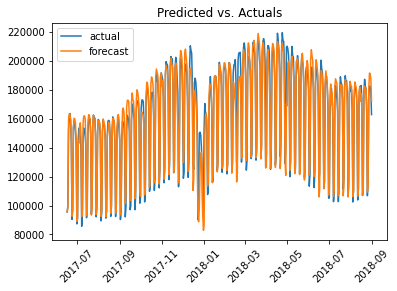

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

fcst_df_h14 = (
    fcst_df.groupby("forecast_origin", as_index=False)
    .last()
    .drop(columns=["forecast_origin"])
)
plt.plot(fcst_df_h14.set_index(time_column_name))
plt.xticks(rotation=45)
plt.title(f"Predicted vs. Actuals")
plt.legend(["actual", "forecast"])
plt.show()

In [ ]:
# Delete the batch endpoint and compute. Do not do it occasionally.
ml_client.batch_endpoints.begin_delete(name=batch_endpoint_name).wait()
ml_client.compute.begin_delete(name=compute_name).wait()

**Deployment**

After we have tested our model on the batch endpoint, we may want to deploy it as a service. Currently no code deployment using mlflow is not supported for forecasting tasks and we will use the workaround which is described in the Deployment section of the [automl-forecasting-task-energy-demand](https://github.com/Azure/azureml-examples/blob/main/sdk/python/jobs/automl-standalone-jobs/automl-forecasting-task-energy-demand/automl-forecasting-task-energy-demand-advanced-mlflow.ipynb) notebook.